In [90]:
import os
import re
import numpy as np
import pandas as pd
import string
import copy
from sklearn import linear_model
from nltk.stem.arlstem import ARLSTem
from nltk.stem import WordNetLemmatizer
from operator import itemgetter, attrgetter
from sklearn.naive_bayes import GaussianNB
from matplotlib import pylab as plt

current_location = os.getcwd()
type(current_location)
amazon_location = current_location+"/sentiment labelled sentences/amazon_cells_labelled.txt"
yelp_location = current_location+"/sentiment labelled sentences/yelp_labelled.txt"
imbd_location = current_location+"/sentiment labelled sentences/imdb_labelled.txt"

In [91]:
amazon_data = pd.read_table(amazon_location,header = None)
amazon_lable = amazon_data.iloc[:,1]
amazon_positive_ratio = float(np.count_nonzero(amazon_lable.values))/amazon_lable.values.size
print amazon_positive_ratio

0.5


In [92]:
yelp_data = pd.read_table(yelp_location,header = None)
yelp_lable = yelp_data.iloc[:,1]
yelp_positive_ratio = float(np.count_nonzero(yelp_lable.values))/yelp_lable.values.size
print yelp_positive_ratio

0.5


In [93]:
imbd_data = pd.read_table(imbd_location,header = None,quoting = 3)
imbd_lable = imbd_data.iloc[:,1]
imbd_positive_ratio = float(np.count_nonzero(imbd_lable.values))/imbd_lable.values.size
print imbd_positive_ratio

0.5


In [94]:
def deleteStemWords(DF):
    DF.iloc[:,0] = DF.iloc[:,0].str.lower()
    for i in range(0,1000):
        DF.iloc[i,0] = ' '+DF.iloc[i,0]
    for c in string.punctuation:  
        if c == '!':
            DF.iloc[:,0] = DF.iloc[:,0].str.replace(c,' !')
        elif c == '?':
            DF.iloc[:,0] = DF.iloc[:,0].str.replace(c,' ?')
        else:
            DF.iloc[:,0] = DF.iloc[:,0].str.replace(c,'')
    DF.iloc[:,0] = DF.iloc[:,0].str.split()
    lemmatizer=WordNetLemmatizer()
    for i in range(0,1000):
        for j in range(0,len(DF.iloc[i,0])):
            if str.isalpha(DF.iloc[i,0][j]):
                DF.iloc[i,0][j] = lemmatizer.lemmatize(DF.iloc[i,0][j],pos = 'v')
                DF.iloc[i,0][j] = lemmatizer.lemmatize(DF.iloc[i,0][j],pos = 'n')
                DF.iloc[i,0][j] = lemmatizer.lemmatize(DF.iloc[i,0][j],pos = 'a')
            if type(DF.iloc[i,0][j]) == unicode:
                DF.iloc[i,0][j] = DF.iloc[i,0][j].encode("ascii")
    return DF

In [95]:
amazon_data = deleteStemWords(amazon_data)
yelp_data = deleteStemWords(yelp_data)
imbd_data = deleteStemWords(imbd_data)

In [96]:
def trainTest(DF):
    DF.iloc[:,0]
    DF_train = []
    DF_test = []
    positive_flag = 0
    negetive_flag = 0
    for i in range(0,1000):
        if positive_flag < 400 or negetive_flag < 400 :
            if DF.loc[i,1] == 0 and negetive_flag <400:
                negetive_flag += 1 
                DF_train.append(list(DF.loc[i,:]))
            elif DF.loc[i,1] == 1 and positive_flag <400:
                positive_flag += 1   
                DF_train.append(list(DF.loc[i,:]))
            else:
                DF_test.append(list(DF.loc[i,:]))
        else:
            DF_test.append(list(DF.loc[i,:]))
    return(DF_train,DF_test)

In [97]:
amazon_train,amazon_test = trainTest(amazon_data)
yelp_train,yelp_test = trainTest(yelp_data)
imbd_train,imbd_test = trainTest(imbd_data)

In [98]:
all_train = []
all_train.extend(amazon_train)
all_train.extend(yelp_train)
all_train.extend(imbd_train)
all_test = []
all_test.extend(amazon_test)
all_test.extend(yelp_test)
all_test.extend(imbd_test)

In [99]:
train_lable = []
for i in range(0,len(all_train)):
    train_lable.append(all_train[i][1])
test_lable = []
for i in range(0,len(all_test)):
    test_lable.append(all_test[i][1])

In [100]:
def creatDic(DF_train):
    DF_dic = {}
    for i in range(0,800):
        for j in range(0,len(DF_train[i][0])):
            if DF_dic.get(DF_train[i][0][j]) == None:
                DF_dic[DF_train[i][0][j]] = 0
    return DF_dic

In [101]:
all_dic = creatDic(all_train)

In [102]:
def getFeatures(words_set,dic,gram):
    if (gram != 1) and (gram != 2):
        return('wrong gram')
    feature_matrix = [[None]*len(dic)]*len(words_set)
    for i in range(0,len(words_set)):
        dic_copy = copy.deepcopy(dic)
        feature_matrix[i] = featureVecter(dic_copy,words_set[i][0],gram)
    return feature_matrix

In [103]:
def featureVecter(DF_dic,review,gram):
    if gram == 1:
        for i in range(0,len(review)):
            if DF_dic.get(review[i]) != None:
                DF_dic[review[i]] = DF_dic.get(review[i]) + 1
    elif gram == 2:
        if len(review[0])<2:
            if DF_dic.get(review[0]) != None:
                DF_dic[review[0]] = DF_dic.get(review[0]) + 1
        else:
            for i in range(0,len(review)-1):
                if DF_dic.get(review[i]+review[i+1]) != None:
                    DF_dic[review[i]+review[i+1]] = DF_dic.get(review[i]+review[i+1]) + 1
    return DF_dic.values()

In [104]:
train_features = getFeatures(all_train,all_dic,1)
test_features = getFeatures(all_test,all_dic,1)

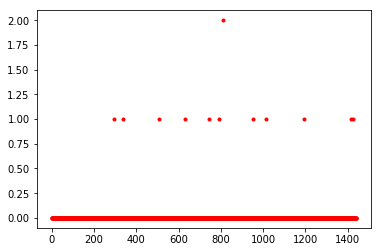

In [105]:
np.set_printoptions(threshold='nan')
plt.plot(train_features[3],'.r')
plt.show()

In [106]:
def normalizeFeatures(features):
    for i in range(0,len(features)):
        if sum(features[i])!=0:
            features[i] = np.array(features[i])/float(sum(features[i]))
        else:
            features[i] = np.array(features[i])

In [107]:
normalizeFeatures(test_features)
normalizeFeatures(train_features)

In [108]:
def lrImplement(train_features,train_lable,test_features,test_lable):
    lr = linear_model.LogisticRegression(multi_class = 'ovr')
    lr.fit(train_features,train_lable)
    lr_test_pre = lr.predict(test_features).astype(int)
    lr_score = lr.score(test_features,test_lable)
    lr_confusion_matrix = confusionMatrix(lr_test_pre,test_lable)
    return lr_score,lr_confusion_matrix

In [109]:
def gnbImplement(train_features,train_lable,test_features,test_lable):
    gnb = GaussianNB()
    gnb_test_pre = gnb.fit(train_features,train_lable).predict(test_features)
    gnb_score = gnb.fit(train_features,train_lable).score(test_features,test_lable)
    gnb_confusion_matrix = confusionMatrix(gnb_test_pre,test_lable)
    return gnb_score,gnb_confusion_matrix

In [110]:
def confusionMatrix(test_pre,test_lable):
    confusion_matrix = [[0 for i in range(2)] for i in range(2)] 
    for i in range(0,600):
        if test_pre[i] == test_lable[i]:
            if test_pre[i] == 1:
                confusion_matrix[0][0] = confusion_matrix[0][0] + 1        #TP
            else:
                confusion_matrix[1][1] = confusion_matrix[1][1] + 1        #TF
        elif test_pre[i] == 1:
            confusion_matrix[1][0] = confusion_matrix[1][0] + 1            #FN
        else:
            confusion_matrix[0][1] = confusion_matrix[0][1] + 1            #FP
    return confusion_matrix

In [111]:
def mostImportantWords(dic,train_features,length):
    lr = linear_model.LogisticRegression(multi_class = 'ovr')
    lr.fit(train_features,train_lable)
    weight_vector = lr.coef_
    sort_index = np.argsort(weight_vector[0])
    words_list = []
    for i in range(length):
        words_list.append(dic.keys()[sort_index[len(sort_index)-1-i]])
    return words_list

In [112]:
# logistic regression 1 gram
lr_score,lr_confusion_matrix= lrImplement(train_features,train_lable,test_features,test_lable)
lr_words_num = 15
lr_words = mostImportantWords(all_dic,train_features,lr_words_num)
print "the fist",lr_words_num,"most important words are: ", lr_words
print "1 gram logistic regression score:",'%6.5f'%lr_score
print "1 gram logistic regression confusion matrix:",lr_confusion_matrix

the fist 15 most important words are:  ['absolutel', 'good', 'extra', 'and', 'must', 'functionality', '!', 'away', 'very', 'charge', 'price', 'i', 'highly', 'figure', 'care']
1 gram logistic regression score: 0.71500
1 gram logistic regression confusion matrix: [[198, 102], [69, 231]]


In [390]:
# naive bayes 1 gram
gnb_score,gnb_confusion_matrix = gnbImplement(train_features,train_lable,test_features,test_lable)
print '1 gram naive bayes score:','%6.5f'%gnb_score
print "1 gram naive bayes confusion matrix:",gnb_confusion_matrix

1 gram naive bayes score: 0.64167
1 gram naive bayes confusion matrix: [[266, 34], [181, 119]]


In [402]:
# 2-gram modle
def creat2GramDic(DF_train):
    DF_dic = {}
    for i in range(0,800):
        if len(DF_train[i][0]) < 2:
            if DF_dic.get(DF_train[i][0][0]) == None:
                DF_dic[DF_train[i][0][0]] = 0
        else:
            for j in range(0,len(DF_train[i][0])-1):
                if DF_dic.get(DF_train[i][0][j]+DF_train[i][0][j+1]) == None:
                    DF_dic[DF_train[i][0][j]+DF_train[i][0][j+1]] = 0
    return DF_dic

In [403]:
all_dic_2g = creat2GramDic(all_train)

In [404]:
test_features_2g = getFeatures(all_test,all_dic_2g,2)
train_features_2g = getFeatures(all_train,all_dic_2g,2)

In [405]:
normalizeFeatures(test_features_2g)
normalizeFeatures(train_features_2g)

In [398]:
# logistic regression 2 gram
lr_score_2g,lr_confusion_matrix_2g= lrImplement(train_features_2g,train_lable,test_features_2g,test_lable)
lr_words_num_2g = 15
lr_words_2g = mostImportantWords(all_dic_2g,train_features,lr_words_num_2g)
print "the fist",lr_words_num,"important words are: ", lr_words_2g
print "2 gram logistic regression score:",'%6.5f'%lr_score_2g
print "2 gram logistic regression confusion matrix:",lr_confusion_matrix_2g

the fist 15 important words are:  ['sometime', 'toreturn', 'ontelephone', 'letyou', u'iplace', u'expect!', u'thatit', 'undergrey', 'ofall', 'solidkeyboard', u'beperhaps', 'nothappy', 'ofuse', 'atan', 'easyto']
2 gram logistic regression score: 0.62500
2 gram logistic regression confusion matrix: [[137, 163], [62, 238]]


In [399]:
# naive bayes 2 gram
gnb_score_2g,gnb_confusion_matrix_2g = gnbImplement(train_features_2g,train_lable,test_features_2g,test_lable)
print "2 gram naive bayes score:",'%6.5f'%gnb_score_2g
print "2 gram naive bayes confusion matrix:",gnb_confusion_matrix_2g

2 gram naive bayes score: 0.64500
2 gram naive bayes confusion matrix: [[262, 38], [175, 125]]


In [424]:
#PCA
def getAverage(data):
    average_train_features = data[0]
    for i in range(1,len(data)):
        average_train_features = average_train_features + data[i]
    average_train_features = average_train_features/sum(average_train_features)
    return average_train_features

In [401]:
def computeV(data,q):
    U,D,Vt = np.linalg.svd(data)
    Vq = np.transpose(Vt[0:q])
    return Vq

In [395]:
def PCA(data,average,q):
    Vq = computeV(data,q)
    datanew = copy.deepcopy(data)
    for i in range(len(data)):
        lamda = np.dot(np.transpose(Vq),(data[i]-average))
        datanew[i] = average + np.dot(Vq,lamda)
    return datanew

In [429]:
def repetition1GramQ(q):
    for qf in q:
        train_features_q = PCA(train_features,average_train_features,qf)
        test_features_q = PCA(test_features,average_test_features,qf)
        normalizeFeatures(test_features_q)
        normalizeFeatures(train_features_q)
        lr_score_q,lr_confusion_matrix_q= lrImplement(train_features_q,train_lable,test_features_q,test_lable)
        lr_words_num_q = 15
        lr_words_q = mostImportantWords(all_dic,train_features_q,lr_words_num_q)
        print "the fist",lr_words_num_q,"important words are: ", lr_words_q
        print "1 gram logistic regression score:",'%6.5f'%lr_score_q ," with q =",qf
        print "1 gram logistic regression confusion matrix:",lr_confusion_matrix_q," with q =",qf
        gnb_score_q,gnb_confusion_matrix_q = gnbImplement(train_features_q,train_lable,test_features_q,test_lable)
        print 
        print "1 gram naive bayes score:",'%6.5f'%gnb_score_q ," with q =",qf
        print "1 gram naive bayes confusion matrix:",gnb_confusion_matrix_q," with q =",qf
        print '\n'*2

In [431]:
def repetition2GramQ(q):
    for qf in q:
        train_features_q_2g = PCA(train_features_2g,average_train_features_2g,qf)
        test_features_q_2g = PCA(test_features_2g,average_test_features_2g,qf)
        normalizeFeatures(test_features_q_2g)
        normalizeFeatures(train_features_q_2g)
        lr_score_q_2g,lr_confusion_matrix_q_2g= lrImplement(train_features_q_2g,train_lable,test_features_q_2g,test_lable)
        lr_words_num_q_2g = 15
        lr_words_q_2g = mostImportantWords(all_dic_2g,train_features_q_2g,lr_words_num_q_2g)
        print "the fist",lr_words_num_q_2g,"important words are: ", lr_words_q_2g        
        print "2 gram logistic regression score:",'%6.5f'%lr_score_q_2g ," with q =",qf
        print "2 gram logistic regression confusion matrix:",lr_confusion_matrix_q_2g," with q =",qf
        gnb_score_q_2g,gnb_confusion_matrix_q_2g = gnbImplement(train_features_q_2g,train_lable,test_features_q_2g,test_lable)
        print 
        print "2 gram naive bayes score:",'%6.5f'%gnb_score_q_2g ," with q =",qf
        print "2 gram naive bayes confusion matrix:",gnb_confusion_matrix_q_2g," with q =",qf
        print '\n'*2

In [432]:
average_train_features = getAverage(train_features)
average_test_features = getAverage(test_features)
average_train_features_2g = getAverage(train_features_2g)
average_test_features_2g = getAverage(test_features_2g)

In [433]:
repetition1GramQ([10,50,100])

the fist 15 important words are:  ['absolutel', 'and', 'good', '!', 'very', 'install', 'excellent', 'too', 'price', 'buyerbe', 'a', 'either', 'value', 'include', 'magical']
1 gram logistic regression score: 0.58667  with q = 10
1 gram logistic regression confusion matrix: [[138, 162], [86, 214]]  with q = 10

1 gram naive bayes score: 0.50000  with q = 10
1 gram naive bayes confusion matrix: [[300, 0], [300, 0]]  with q = 10



the fist 15 important words are:  ['absolutel', 'good', 'and', 'extra', 'functionality', 'must', '!', 'i', 'very', 'place', 'unit', 'switch', 'price', 'excellent', 'an']
1 gram logistic regression score: 0.66667  with q = 50
1 gram logistic regression confusion matrix: [[179, 121], [79, 221]]  with q = 50

1 gram naive bayes score: 0.54833  with q = 50
1 gram naive bayes confusion matrix: [[63, 237], [34, 266]]  with q = 50



the fist 15 important words are:  ['absolutel', 'good', 'extra', 'and', 'must', 'functionality', 'away', '!', 'very', 'charge', 'price', 

In [434]:
repetition2GramQ([10,50,100])

the fist 15 important words are:  ['whoseear', 'ripby', 'againfor', 'noisecancel', 'andgo', 'best!', 'trulyawful', 'thesame', 'arelative', 'andgreat', 'mostlyit', 'confortableto', 'andcontact', 'fromthem', 'thesound']
2 gram logistic regression score: 0.49500  with q = 10
2 gram logistic regression confusion matrix: [[264, 36], [267, 33]]  with q = 10

2 gram naive bayes score: 0.50000  with q = 10
2 gram naive bayes confusion matrix: [[300, 0], [300, 0]]  with q = 10



the fist 15 important words are:  ['whoseear', 'ripby', 'andgo', 'shieldbe', 'iwaste', 'thegenuine', 'openthere', 'mostlyit', 'qualitysound', 'againfor', 'ofwarranty', 'willprobably', 'receipti', 'andgreat', 'myfavorite']
2 gram logistic regression score: 0.57333  with q = 50
2 gram logistic regression confusion matrix: [[107, 193], [63, 237]]  with q = 50

2 gram naive bayes score: 0.51500  with q = 50
2 gram naive bayes confusion matrix: [[292, 8], [283, 17]]  with q = 50



the fist 15 important words are:  ['whosee